# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

In [3]:
print(tf.__version__)

1.14.0


## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [4]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [22]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)
df = df.iloc[:,:10].dropna()


# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [23]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 128)          1152        input_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          16512       dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           8256        dense_4[0][0]                    
____________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [24]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [25]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 0s 484us/sample - loss: 232.5502 - y1_output_loss: 113.5616 - y2_output_loss: 116.8564 - y1_output_root_mean_squared_error: 10.7065 - y2_output_root_mean_squared_error: 10.8592 - val_loss: 31.7615 - val_y1_output_loss: 12.8001 - val_y2_output_loss: 18.0518 - val_y1_output_root_mean_squared_error: 3.6371 - val_y2_output_root_mean_squared_error: 4.3050
Epoch 2/500
614/614 [==============================] - 0s 275us/sample - loss: 29.9957 - y1_output_loss: 12.5749 - y2_output_loss: 18.6156 - y1_output_root_mean_squared_error: 3.5017 - y2_output_root_mean_squared_error: 4.2111 - val_loss: 265.7685 - val_y1_output_loss: 37.5459 - val_y2_output_loss: 222.5407 - val_y1_output_root_mean_squared_error: 6.1909 - val_y2_output_root_mean_squared_error: 15.0811
Epoch 3/500
614/614 [==============================] - 0s 282us/sample - loss: 37.8907 - y1_output_loss: 12.8306 - y2_output_loss: 24.8419 -

614/614 [==============================] - 0s 280us/sample - loss: 13.7194 - y1_output_loss: 5.5025 - y2_output_loss: 8.3662 - y1_output_root_mean_squared_error: 2.3232 - y2_output_root_mean_squared_error: 2.8848 - val_loss: 24.4085 - val_y1_output_loss: 6.4241 - val_y2_output_loss: 17.2476 - val_y1_output_root_mean_squared_error: 2.5676 - val_y2_output_root_mean_squared_error: 4.2209
Epoch 22/500
614/614 [==============================] - 0s 274us/sample - loss: 16.4505 - y1_output_loss: 6.2108 - y2_output_loss: 10.1034 - y1_output_root_mean_squared_error: 2.5030 - y2_output_root_mean_squared_error: 3.1915 - val_loss: 12.1453 - val_y1_output_loss: 4.9579 - val_y2_output_loss: 7.3400 - val_y1_output_root_mean_squared_error: 2.2498 - val_y2_output_root_mean_squared_error: 2.6615
Epoch 23/500
614/614 [==============================] - 0s 274us/sample - loss: 17.9531 - y1_output_loss: 6.1618 - y2_output_loss: 11.6776 - y1_output_root_mean_squared_error: 2.4920 - y2_output_root_mean_square

614/614 [==============================] - 0s 279us/sample - loss: 11.3827 - y1_output_loss: 3.6616 - y2_output_loss: 7.8513 - y1_output_root_mean_squared_error: 1.9047 - y2_output_root_mean_squared_error: 2.7848 - val_loss: 17.2257 - val_y1_output_loss: 4.1916 - val_y2_output_loss: 13.3326 - val_y1_output_root_mean_squared_error: 2.0316 - val_y2_output_root_mean_squared_error: 3.6192
Epoch 42/500
614/614 [==============================] - 0s 277us/sample - loss: 7.9789 - y1_output_loss: 2.6847 - y2_output_loss: 5.3020 - y1_output_root_mean_squared_error: 1.6374 - y2_output_root_mean_squared_error: 2.3017 - val_loss: 10.8922 - val_y1_output_loss: 4.7055 - val_y2_output_loss: 6.0217 - val_y1_output_root_mean_squared_error: 2.1910 - val_y2_output_root_mean_squared_error: 2.4681
Epoch 43/500
614/614 [==============================] - 0s 272us/sample - loss: 9.3143 - y1_output_loss: 2.9851 - y2_output_loss: 6.3396 - y1_output_root_mean_squared_error: 1.7309 - y2_output_root_mean_squared_er

Epoch 62/500
614/614 [==============================] - 0s 277us/sample - loss: 6.5383 - y1_output_loss: 1.7388 - y2_output_loss: 4.7645 - y1_output_root_mean_squared_error: 1.3193 - y2_output_root_mean_squared_error: 2.1904 - val_loss: 5.6752 - val_y1_output_loss: 2.0266 - val_y2_output_loss: 3.5247 - val_y1_output_root_mean_squared_error: 1.4351 - val_y2_output_root_mean_squared_error: 1.9015
Epoch 63/500
614/614 [==============================] - 0s 272us/sample - loss: 6.7516 - y1_output_loss: 1.8655 - y2_output_loss: 4.8768 - y1_output_root_mean_squared_error: 1.3689 - y2_output_root_mean_squared_error: 2.2086 - val_loss: 5.9451 - val_y1_output_loss: 1.6223 - val_y2_output_loss: 4.1719 - val_y1_output_root_mean_squared_error: 1.2889 - val_y2_output_root_mean_squared_error: 2.0698
Epoch 64/500
614/614 [==============================] - 0s 269us/sample - loss: 5.5525 - y1_output_loss: 1.4219 - y2_output_loss: 4.1110 - y1_output_root_mean_squared_error: 1.1973 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 274us/sample - loss: 3.9992 - y1_output_loss: 1.0270 - y2_output_loss: 3.0442 - y1_output_root_mean_squared_error: 1.0130 - y2_output_root_mean_squared_error: 1.7242 - val_loss: 19.4945 - val_y1_output_loss: 8.2402 - val_y2_output_loss: 12.8254 - val_y1_output_root_mean_squared_error: 2.7791 - val_y2_output_root_mean_squared_error: 3.4309
Epoch 84/500
614/614 [==============================] - 0s 277us/sample - loss: 3.7932 - y1_output_loss: 1.0039 - y2_output_loss: 2.7742 - y1_output_root_mean_squared_error: 1.0021 - y2_output_root_mean_squared_error: 1.6700 - val_loss: 3.4987 - val_y1_output_loss: 1.0394 - val_y2_output_loss: 2.3347 - val_y1_output_root_mean_squared_error: 1.0375 - val_y2_output_root_mean_squared_error: 1.5564
Epoch 85/500
614/614 [==============================] - 0s 269us/sample - loss: 2.8254 - y1_output_loss: 0.5781 - y2_output_loss: 2.2318 - y1_output_root_mean_squared_error: 0.7611 - y2_output_root_mean

614/614 [==============================] - 0s 280us/sample - loss: 6.4500 - y1_output_loss: 1.9406 - y2_output_loss: 4.4615 - y1_output_root_mean_squared_error: 1.3986 - y2_output_root_mean_squared_error: 2.1199 - val_loss: 2.7335 - val_y1_output_loss: 0.5312 - val_y2_output_loss: 2.3285 - val_y1_output_root_mean_squared_error: 0.7401 - val_y2_output_root_mean_squared_error: 1.4784
Epoch 104/500
614/614 [==============================] - 0s 279us/sample - loss: 3.3827 - y1_output_loss: 0.7529 - y2_output_loss: 2.6270 - y1_output_root_mean_squared_error: 0.8715 - y2_output_root_mean_squared_error: 1.6197 - val_loss: 3.2286 - val_y1_output_loss: 0.8200 - val_y2_output_loss: 2.4317 - val_y1_output_root_mean_squared_error: 0.9030 - val_y2_output_root_mean_squared_error: 1.5534
Epoch 105/500
614/614 [==============================] - 0s 270us/sample - loss: 2.4425 - y1_output_loss: 0.5335 - y2_output_loss: 1.8859 - y1_output_root_mean_squared_error: 0.7339 - y2_output_root_mean_squared_erro

Epoch 124/500
614/614 [==============================] - 0s 280us/sample - loss: 1.9512 - y1_output_loss: 0.4261 - y2_output_loss: 1.5080 - y1_output_root_mean_squared_error: 0.6552 - y2_output_root_mean_squared_error: 1.2337 - val_loss: 3.5499 - val_y1_output_loss: 1.2461 - val_y2_output_loss: 2.2509 - val_y1_output_root_mean_squared_error: 1.1212 - val_y2_output_root_mean_squared_error: 1.5142
Epoch 125/500
614/614 [==============================] - 0s 295us/sample - loss: 2.0623 - y1_output_loss: 0.4395 - y2_output_loss: 1.6414 - y1_output_root_mean_squared_error: 0.6625 - y2_output_root_mean_squared_error: 1.2741 - val_loss: 5.6567 - val_y1_output_loss: 2.1057 - val_y2_output_loss: 3.6193 - val_y1_output_root_mean_squared_error: 1.4267 - val_y2_output_root_mean_squared_error: 1.9030
Epoch 126/500
614/614 [==============================] - 0s 280us/sample - loss: 3.3002 - y1_output_loss: 0.7292 - y2_output_loss: 2.6020 - y1_output_root_mean_squared_error: 0.8516 - y2_output_root_mea

614/614 [==============================] - 0s 326us/sample - loss: 1.8882 - y1_output_loss: 0.3931 - y2_output_loss: 1.4949 - y1_output_root_mean_squared_error: 0.6251 - y2_output_root_mean_squared_error: 1.2237 - val_loss: 3.8475 - val_y1_output_loss: 0.8228 - val_y2_output_loss: 3.0809 - val_y1_output_root_mean_squared_error: 0.8881 - val_y2_output_root_mean_squared_error: 1.7489
Epoch 145/500
614/614 [==============================] - 0s 313us/sample - loss: 1.9653 - y1_output_loss: 0.3733 - y2_output_loss: 1.5827 - y1_output_root_mean_squared_error: 0.6135 - y2_output_root_mean_squared_error: 1.2605 - val_loss: 2.4412 - val_y1_output_loss: 0.5007 - val_y2_output_loss: 1.8616 - val_y1_output_root_mean_squared_error: 0.7193 - val_y2_output_root_mean_squared_error: 1.3870
Epoch 146/500
614/614 [==============================] - 0s 332us/sample - loss: 2.1867 - y1_output_loss: 0.4188 - y2_output_loss: 1.8008 - y1_output_root_mean_squared_error: 0.6402 - y2_output_root_mean_squared_erro

Epoch 165/500
614/614 [==============================] - 0s 301us/sample - loss: 2.4772 - y1_output_loss: 0.6361 - y2_output_loss: 1.8298 - y1_output_root_mean_squared_error: 0.7999 - y2_output_root_mean_squared_error: 1.3555 - val_loss: 2.3660 - val_y1_output_loss: 0.4633 - val_y2_output_loss: 1.8563 - val_y1_output_root_mean_squared_error: 0.6868 - val_y2_output_root_mean_squared_error: 1.3764
Epoch 166/500
614/614 [==============================] - 0s 311us/sample - loss: 1.3473 - y1_output_loss: 0.3165 - y2_output_loss: 1.0298 - y1_output_root_mean_squared_error: 0.5590 - y2_output_root_mean_squared_error: 1.0173 - val_loss: 1.7883 - val_y1_output_loss: 0.3439 - val_y2_output_loss: 1.3974 - val_y1_output_root_mean_squared_error: 0.5912 - val_y2_output_root_mean_squared_error: 1.1995
Epoch 167/500
614/614 [==============================] - 0s 308us/sample - loss: 1.4092 - y1_output_loss: 0.2895 - y2_output_loss: 1.1508 - y1_output_root_mean_squared_error: 0.5381 - y2_output_root_mea

614/614 [==============================] - 0s 285us/sample - loss: 1.4957 - y1_output_loss: 0.2883 - y2_output_loss: 1.1947 - y1_output_root_mean_squared_error: 0.5392 - y2_output_root_mean_squared_error: 1.0977 - val_loss: 1.6805 - val_y1_output_loss: 0.3917 - val_y2_output_loss: 1.5066 - val_y1_output_root_mean_squared_error: 0.6352 - val_y2_output_root_mean_squared_error: 1.1301
Epoch 186/500
614/614 [==============================] - 0s 274us/sample - loss: 1.6782 - y1_output_loss: 0.3284 - y2_output_loss: 1.3353 - y1_output_root_mean_squared_error: 0.5754 - y2_output_root_mean_squared_error: 1.1607 - val_loss: 1.4274 - val_y1_output_loss: 0.3679 - val_y2_output_loss: 1.0642 - val_y1_output_root_mean_squared_error: 0.6011 - val_y2_output_root_mean_squared_error: 1.0325
Epoch 187/500
614/614 [==============================] - 0s 282us/sample - loss: 1.4989 - y1_output_loss: 0.3104 - y2_output_loss: 1.1757 - y1_output_root_mean_squared_error: 0.5585 - y2_output_root_mean_squared_erro

Epoch 206/500
614/614 [==============================] - 0s 300us/sample - loss: 1.3792 - y1_output_loss: 0.2620 - y2_output_loss: 1.1066 - y1_output_root_mean_squared_error: 0.5136 - y2_output_root_mean_squared_error: 1.0561 - val_loss: 1.7433 - val_y1_output_loss: 0.4555 - val_y2_output_loss: 1.3387 - val_y1_output_root_mean_squared_error: 0.5979 - val_y2_output_root_mean_squared_error: 1.1773
Epoch 207/500
614/614 [==============================] - 0s 296us/sample - loss: 1.5045 - y1_output_loss: 0.2718 - y2_output_loss: 1.2210 - y1_output_root_mean_squared_error: 0.5219 - y2_output_root_mean_squared_error: 1.1100 - val_loss: 1.8372 - val_y1_output_loss: 0.4893 - val_y2_output_loss: 1.2838 - val_y1_output_root_mean_squared_error: 0.7111 - val_y2_output_root_mean_squared_error: 1.1539
Epoch 208/500
614/614 [==============================] - 0s 295us/sample - loss: 1.6278 - y1_output_loss: 0.4127 - y2_output_loss: 1.2129 - y1_output_root_mean_squared_error: 0.6435 - y2_output_root_mea

614/614 [==============================] - 0s 287us/sample - loss: 1.5517 - y1_output_loss: 0.3171 - y2_output_loss: 1.2506 - y1_output_root_mean_squared_error: 0.5640 - y2_output_root_mean_squared_error: 1.1107 - val_loss: 7.4163 - val_y1_output_loss: 0.7142 - val_y2_output_loss: 6.6865 - val_y1_output_root_mean_squared_error: 0.8503 - val_y2_output_root_mean_squared_error: 2.5871
Epoch 227/500
614/614 [==============================] - 0s 282us/sample - loss: 1.4497 - y1_output_loss: 0.2635 - y2_output_loss: 1.1759 - y1_output_root_mean_squared_error: 0.5142 - y2_output_root_mean_squared_error: 1.0887 - val_loss: 1.9043 - val_y1_output_loss: 0.5482 - val_y2_output_loss: 1.4055 - val_y1_output_root_mean_squared_error: 0.7456 - val_y2_output_root_mean_squared_error: 1.1612
Epoch 228/500
614/614 [==============================] - 0s 287us/sample - loss: 1.3681 - y1_output_loss: 0.2764 - y2_output_loss: 1.0930 - y1_output_root_mean_squared_error: 0.5277 - y2_output_root_mean_squared_erro

Epoch 247/500
614/614 [==============================] - 0s 290us/sample - loss: 0.9618 - y1_output_loss: 0.1612 - y2_output_loss: 0.7971 - y1_output_root_mean_squared_error: 0.4012 - y2_output_root_mean_squared_error: 0.8949 - val_loss: 1.5238 - val_y1_output_loss: 0.4036 - val_y2_output_loss: 1.1387 - val_y1_output_root_mean_squared_error: 0.6437 - val_y2_output_root_mean_squared_error: 1.0533
Epoch 248/500
614/614 [==============================] - 0s 275us/sample - loss: 2.2055 - y1_output_loss: 0.6222 - y2_output_loss: 1.5699 - y1_output_root_mean_squared_error: 0.7911 - y2_output_root_mean_squared_error: 1.2568 - val_loss: 1.5815 - val_y1_output_loss: 0.2901 - val_y2_output_loss: 1.2782 - val_y1_output_root_mean_squared_error: 0.5192 - val_y2_output_root_mean_squared_error: 1.1454
Epoch 249/500
614/614 [==============================] - 0s 292us/sample - loss: 0.9950 - y1_output_loss: 0.1844 - y2_output_loss: 0.8033 - y1_output_root_mean_squared_error: 0.4313 - y2_output_root_mea

614/614 [==============================] - 0s 269us/sample - loss: 0.9322 - y1_output_loss: 0.2079 - y2_output_loss: 0.7188 - y1_output_root_mean_squared_error: 0.4571 - y2_output_root_mean_squared_error: 0.8505 - val_loss: 1.3642 - val_y1_output_loss: 0.2879 - val_y2_output_loss: 1.0891 - val_y1_output_root_mean_squared_error: 0.5424 - val_y2_output_root_mean_squared_error: 1.0344
Epoch 268/500
614/614 [==============================] - 0s 262us/sample - loss: 0.8919 - y1_output_loss: 0.1975 - y2_output_loss: 0.6862 - y1_output_root_mean_squared_error: 0.4463 - y2_output_root_mean_squared_error: 0.8323 - val_loss: 1.3265 - val_y1_output_loss: 0.2659 - val_y2_output_loss: 1.0230 - val_y1_output_root_mean_squared_error: 0.5146 - val_y2_output_root_mean_squared_error: 1.0304
Epoch 269/500
614/614 [==============================] - 0s 272us/sample - loss: 1.0460 - y1_output_loss: 0.2153 - y2_output_loss: 0.8288 - y1_output_root_mean_squared_error: 0.4608 - y2_output_root_mean_squared_erro

Epoch 288/500
614/614 [==============================] - 0s 275us/sample - loss: 0.9849 - y1_output_loss: 0.2064 - y2_output_loss: 0.7854 - y1_output_root_mean_squared_error: 0.4536 - y2_output_root_mean_squared_error: 0.8827 - val_loss: 4.0971 - val_y1_output_loss: 1.3149 - val_y2_output_loss: 2.8663 - val_y1_output_root_mean_squared_error: 1.1212 - val_y2_output_root_mean_squared_error: 1.6852
Epoch 289/500
614/614 [==============================] - 0s 274us/sample - loss: 3.0391 - y1_output_loss: 0.8089 - y2_output_loss: 2.2145 - y1_output_root_mean_squared_error: 0.9008 - y2_output_root_mean_squared_error: 1.4925 - val_loss: 2.6262 - val_y1_output_loss: 0.7521 - val_y2_output_loss: 2.0330 - val_y1_output_root_mean_squared_error: 0.8587 - val_y2_output_root_mean_squared_error: 1.3743
Epoch 290/500
614/614 [==============================] - 0s 277us/sample - loss: 1.1629 - y1_output_loss: 0.2101 - y2_output_loss: 0.9485 - y1_output_root_mean_squared_error: 0.4603 - y2_output_root_mea

614/614 [==============================] - 0s 274us/sample - loss: 0.6018 - y1_output_loss: 0.1406 - y2_output_loss: 0.4593 - y1_output_root_mean_squared_error: 0.3750 - y2_output_root_mean_squared_error: 0.6791 - val_loss: 1.2488 - val_y1_output_loss: 0.2993 - val_y2_output_loss: 0.9413 - val_y1_output_root_mean_squared_error: 0.5493 - val_y2_output_root_mean_squared_error: 0.9732
Epoch 309/500
614/614 [==============================] - 0s 270us/sample - loss: 0.7184 - y1_output_loss: 0.1566 - y2_output_loss: 0.5624 - y1_output_root_mean_squared_error: 0.3966 - y2_output_root_mean_squared_error: 0.7491 - val_loss: 2.6724 - val_y1_output_loss: 0.6335 - val_y2_output_loss: 2.1548 - val_y1_output_root_mean_squared_error: 0.7857 - val_y2_output_root_mean_squared_error: 1.4335
Epoch 310/500
614/614 [==============================] - 0s 277us/sample - loss: 0.9791 - y1_output_loss: 0.2359 - y2_output_loss: 0.7369 - y1_output_root_mean_squared_error: 0.4865 - y2_output_root_mean_squared_erro

Epoch 329/500
614/614 [==============================] - ETA: 0s - loss: 0.6798 - y1_output_loss: 0.1676 - y2_output_loss: 0.5122 - y1_output_root_mean_squared_error: 0.4094 - y2_output_root_mean_squared_error: 0.715 - 0s 285us/sample - loss: 0.6933 - y1_output_loss: 0.1712 - y2_output_loss: 0.5167 - y1_output_root_mean_squared_error: 0.4145 - y2_output_root_mean_squared_error: 0.7222 - val_loss: 1.0523 - val_y1_output_loss: 0.2047 - val_y2_output_loss: 0.8424 - val_y1_output_root_mean_squared_error: 0.4560 - val_y2_output_root_mean_squared_error: 0.9189
Epoch 330/500
614/614 [==============================] - 0s 270us/sample - loss: 0.6664 - y1_output_loss: 0.1686 - y2_output_loss: 0.4918 - y1_output_root_mean_squared_error: 0.4125 - y2_output_root_mean_squared_error: 0.7044 - val_loss: 1.0110 - val_y1_output_loss: 0.2257 - val_y2_output_loss: 0.7997 - val_y1_output_root_mean_squared_error: 0.4831 - val_y2_output_root_mean_squared_error: 0.8818
Epoch 331/500
614/614 [=================

614/614 [==============================] - 0s 347us/sample - loss: 0.9264 - y1_output_loss: 0.2076 - y2_output_loss: 0.7156 - y1_output_root_mean_squared_error: 0.4566 - y2_output_root_mean_squared_error: 0.8473 - val_loss: 1.2709 - val_y1_output_loss: 0.2996 - val_y2_output_loss: 0.9580 - val_y1_output_root_mean_squared_error: 0.5494 - val_y2_output_root_mean_squared_error: 0.9844
Epoch 350/500
614/614 [==============================] - 0s 316us/sample - loss: 0.5712 - y1_output_loss: 0.1506 - y2_output_loss: 0.4178 - y1_output_root_mean_squared_error: 0.3873 - y2_output_root_mean_squared_error: 0.6490 - val_loss: 1.3201 - val_y1_output_loss: 0.3852 - val_y2_output_loss: 0.9254 - val_y1_output_root_mean_squared_error: 0.6145 - val_y2_output_root_mean_squared_error: 0.9708
Epoch 351/500
614/614 [==============================] - 0s 318us/sample - loss: 0.7262 - y1_output_loss: 0.1755 - y2_output_loss: 0.5464 - y1_output_root_mean_squared_error: 0.4204 - y2_output_root_mean_squared_erro

Epoch 370/500
614/614 [==============================] - 0s 272us/sample - loss: 0.6117 - y1_output_loss: 0.1538 - y2_output_loss: 0.4566 - y1_output_root_mean_squared_error: 0.3927 - y2_output_root_mean_squared_error: 0.6764 - val_loss: 0.9939 - val_y1_output_loss: 0.2310 - val_y2_output_loss: 0.7439 - val_y1_output_root_mean_squared_error: 0.4815 - val_y2_output_root_mean_squared_error: 0.8729
Epoch 371/500
614/614 [==============================] - 0s 267us/sample - loss: 0.6328 - y1_output_loss: 0.1777 - y2_output_loss: 0.4569 - y1_output_root_mean_squared_error: 0.4188 - y2_output_root_mean_squared_error: 0.6763 - val_loss: 2.0430 - val_y1_output_loss: 0.7749 - val_y2_output_loss: 1.2414 - val_y1_output_root_mean_squared_error: 0.8891 - val_y2_output_root_mean_squared_error: 1.1192
Epoch 372/500
614/614 [==============================] - 0s 270us/sample - loss: 0.7514 - y1_output_loss: 0.1928 - y2_output_loss: 0.5547 - y1_output_root_mean_squared_error: 0.4399 - y2_output_root_mea

614/614 [==============================] - 0s 285us/sample - loss: 0.8842 - y1_output_loss: 0.2062 - y2_output_loss: 0.6731 - y1_output_root_mean_squared_error: 0.4551 - y2_output_root_mean_squared_error: 0.8229 - val_loss: 0.9643 - val_y1_output_loss: 0.2176 - val_y2_output_loss: 0.7659 - val_y1_output_root_mean_squared_error: 0.4561 - val_y2_output_root_mean_squared_error: 0.8696
Epoch 391/500
614/614 [==============================] - 0s 291us/sample - loss: 0.5662 - y1_output_loss: 0.1388 - y2_output_loss: 0.4233 - y1_output_root_mean_squared_error: 0.3738 - y2_output_root_mean_squared_error: 0.6531 - val_loss: 1.1414 - val_y1_output_loss: 0.3409 - val_y2_output_loss: 0.7960 - val_y1_output_root_mean_squared_error: 0.5846 - val_y2_output_root_mean_squared_error: 0.8943
Epoch 392/500
614/614 [==============================] - 0s 279us/sample - loss: 0.4821 - y1_output_loss: 0.1291 - y2_output_loss: 0.3514 - y1_output_root_mean_squared_error: 0.3607 - y2_output_root_mean_squared_erro

Epoch 411/500
614/614 [==============================] - 0s 291us/sample - loss: 0.5160 - y1_output_loss: 0.1538 - y2_output_loss: 0.3596 - y1_output_root_mean_squared_error: 0.3937 - y2_output_root_mean_squared_error: 0.6008 - val_loss: 1.1191 - val_y1_output_loss: 0.2070 - val_y2_output_loss: 0.8838 - val_y1_output_root_mean_squared_error: 0.4581 - val_y2_output_root_mean_squared_error: 0.9536
Epoch 412/500
614/614 [==============================] - 0s 290us/sample - loss: 0.6189 - y1_output_loss: 0.1531 - y2_output_loss: 0.4616 - y1_output_root_mean_squared_error: 0.3923 - y2_output_root_mean_squared_error: 0.6819 - val_loss: 0.8572 - val_y1_output_loss: 0.1970 - val_y2_output_loss: 0.6343 - val_y1_output_root_mean_squared_error: 0.4514 - val_y2_output_root_mean_squared_error: 0.8083
Epoch 413/500
614/614 [==============================] - 0s 290us/sample - loss: 0.4722 - y1_output_loss: 0.1249 - y2_output_loss: 0.3490 - y1_output_root_mean_squared_error: 0.3545 - y2_output_root_mea

614/614 [==============================] - 0s 278us/sample - loss: 0.5662 - y1_output_loss: 0.1643 - y2_output_loss: 0.3984 - y1_output_root_mean_squared_error: 0.4069 - y2_output_root_mean_squared_error: 0.6329 - val_loss: 1.0646 - val_y1_output_loss: 0.2365 - val_y2_output_loss: 0.8030 - val_y1_output_root_mean_squared_error: 0.4929 - val_y2_output_root_mean_squared_error: 0.9065
Epoch 432/500
614/614 [==============================] - 0s 275us/sample - loss: 0.4353 - y1_output_loss: 0.1195 - y2_output_loss: 0.3156 - y1_output_root_mean_squared_error: 0.3470 - y2_output_root_mean_squared_error: 0.5611 - val_loss: 0.8465 - val_y1_output_loss: 0.2349 - val_y2_output_loss: 0.6104 - val_y1_output_root_mean_squared_error: 0.4858 - val_y2_output_root_mean_squared_error: 0.7813
Epoch 433/500
614/614 [==============================] - 0s 277us/sample - loss: 0.4676 - y1_output_loss: 0.1140 - y2_output_loss: 0.3737 - y1_output_root_mean_squared_error: 0.3388 - y2_output_root_mean_squared_erro

Epoch 452/500
614/614 [==============================] - 0s 287us/sample - loss: 0.4966 - y1_output_loss: 0.1284 - y2_output_loss: 0.3669 - y1_output_root_mean_squared_error: 0.3586 - y2_output_root_mean_squared_error: 0.6067 - val_loss: 1.0104 - val_y1_output_loss: 0.2066 - val_y2_output_loss: 0.7758 - val_y1_output_root_mean_squared_error: 0.4622 - val_y2_output_root_mean_squared_error: 0.8926
Epoch 453/500
614/614 [==============================] - 0s 274us/sample - loss: 0.3962 - y1_output_loss: 0.1149 - y2_output_loss: 0.2834 - y1_output_root_mean_squared_error: 0.3388 - y2_output_root_mean_squared_error: 0.5304 - val_loss: 1.0476 - val_y1_output_loss: 0.1990 - val_y2_output_loss: 0.8407 - val_y1_output_root_mean_squared_error: 0.4436 - val_y2_output_root_mean_squared_error: 0.9224
Epoch 454/500
614/614 [==============================] - 0s 275us/sample - loss: 0.5027 - y1_output_loss: 0.1414 - y2_output_loss: 0.3590 - y1_output_root_mean_squared_error: 0.3755 - y2_output_root_mea

614/614 [==============================] - 0s 277us/sample - loss: 0.4042 - y1_output_loss: 0.1123 - y2_output_loss: 0.2929 - y1_output_root_mean_squared_error: 0.3362 - y2_output_root_mean_squared_error: 0.5395 - val_loss: 0.9752 - val_y1_output_loss: 0.2335 - val_y2_output_loss: 0.7204 - val_y1_output_root_mean_squared_error: 0.4815 - val_y2_output_root_mean_squared_error: 0.8622
Epoch 473/500
614/614 [==============================] - 0s 273us/sample - loss: 0.5616 - y1_output_loss: 0.1397 - y2_output_loss: 0.4213 - y1_output_root_mean_squared_error: 0.3736 - y2_output_root_mean_squared_error: 0.6496 - val_loss: 1.4167 - val_y1_output_loss: 0.3341 - val_y2_output_loss: 1.0821 - val_y1_output_root_mean_squared_error: 0.5813 - val_y2_output_root_mean_squared_error: 1.0387
Epoch 474/500
614/614 [==============================] - 0s 277us/sample - loss: 0.4889 - y1_output_loss: 0.1287 - y2_output_loss: 0.3581 - y1_output_root_mean_squared_error: 0.3580 - y2_output_root_mean_squared_erro

Epoch 493/500
614/614 [==============================] - 0s 280us/sample - loss: 0.4321 - y1_output_loss: 0.1331 - y2_output_loss: 0.2990 - y1_output_root_mean_squared_error: 0.3653 - y2_output_root_mean_squared_error: 0.5465 - val_loss: 1.3197 - val_y1_output_loss: 0.4936 - val_y2_output_loss: 0.8263 - val_y1_output_root_mean_squared_error: 0.7149 - val_y2_output_root_mean_squared_error: 0.8993
Epoch 494/500
614/614 [==============================] - 0s 275us/sample - loss: 0.4220 - y1_output_loss: 0.1336 - y2_output_loss: 0.2899 - y1_output_root_mean_squared_error: 0.3669 - y2_output_root_mean_squared_error: 0.5361 - val_loss: 1.3026 - val_y1_output_loss: 0.2481 - val_y2_output_loss: 1.0153 - val_y1_output_root_mean_squared_error: 0.5059 - val_y2_output_root_mean_squared_error: 1.0230
Epoch 495/500
614/614 [==============================] - 0s 273us/sample - loss: 0.5805 - y1_output_loss: 0.1557 - y2_output_loss: 0.4232 - y1_output_root_mean_squared_error: 0.3934 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [26]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 58us/sample - loss: 0.8930 - y1_output_loss: 0.2285 - y2_output_loss: 0.6582 - y1_output_root_mean_squared_error: 0.4840 - y2_output_root_mean_squared_error: 0.8116
Loss = 0.8930417392160985, Y1_loss = 0.2284553349018097, Y1_mse = 0.4840465784072876, Y2_loss = 0.6581535935401917, Y2_mse = 0.8116284012794495


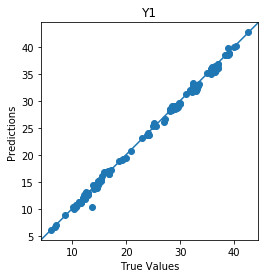

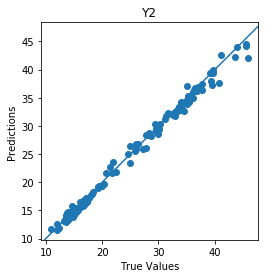

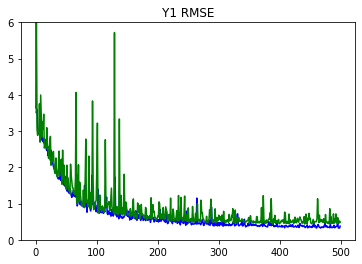

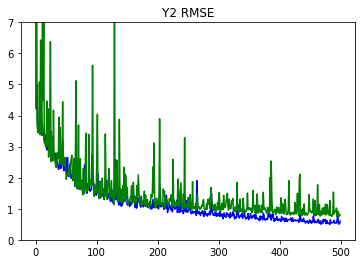

In [27]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)